# Medical Segmentation Notebook Study

Note: if running in Google Colab, make sure you select T4 as the GPU

## SETUP

### Load Environment Variables

In [1]:
COLAB = False

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

In [2]:
import os

HOME = os.getcwd()
os.chdir(HOME)

DATA_PATH = os.path.expanduser(os.path.join("~", "Datasets", "Totalsegmentator_dataset_v201"))
PREDICTIONS_PATH = f"{HOME}/Predictions"


In [3]:
TOTAL_SEGMENTATOR = { "name" : "Total Segmentator", "setup" : False }
SAM =  { "name" : "SAM", "setup" : False }

### Install Packages

In [4]:

if TOTAL_SEGMENTATOR["setup"]:
  !pip install git+https://github.com/wasserth/TotalSegmentator.git
  !pip install pyvista
  !pip install xmltodict
  !pip install --upgrade acvl_utils==0.2
  !pip install ipywidgets
  !pip install trame
  !conda install -c conda-forge trame

else:
  print("TOTAL SEGMENTATOR already installed")


TOTAL SEGMENTATOR already installed


### Imports

In [5]:
from eval.metrics import *
from utils.data_processing import *
from utils.data_viz import *
from utils.data_geometry import *

## Dataset Visualisation

In [6]:
dataset = "Totalsegmentator_dataset_v201"
patient_ID = "s0001"
organ = "colon"

path_to_ctscan = os.path.join(patient_ID, "ct.nii.gz")
path_to_mask = os.path.join(patient_ID, "segmentations", f"{organ}.nii.gz")

ct_filepath = os.path.join(DATA_PATH, path_to_ctscan)
ct_output_filepath = os.path.join(HOME, "gifs",  f"{patient_ID}_ct.gif" )

mask_filepath = os.path.join(DATA_PATH, path_to_mask)
output_mask_filepath = os.path.join(HOME,  "gifs",  f"{patient_ID}_{organ}.gif")


In [11]:
# generate gif for ct scan
#show_nii_slices(nii_file_path)
GENERATE_GIF = False

if GENERATE_GIF:
    ct_scan_gif = generate_gif(ct_filepath, output_filepath=ct_output_filepath)
    ct_scan_segm_gif = generate_gif(mask_filepath, output_filepath=output_mask_filepath)
else:
    ct_scan_gif = os.path.join(HOME, "gifs",  f"{patient_ID}_ct.gif" )
    ct_scan_segm_gif = os.path.join(HOME,  "gifs",  f"{patient_ID}_{organ}.gif")
   
    

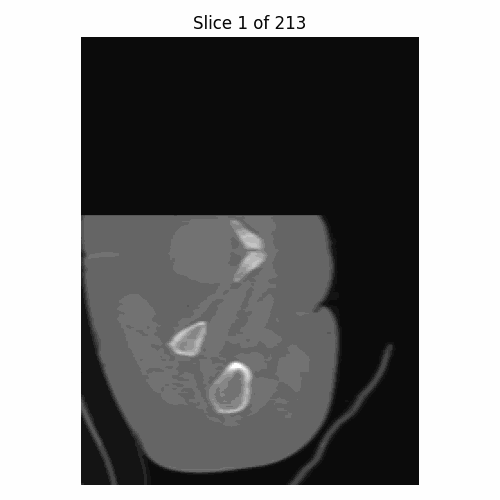

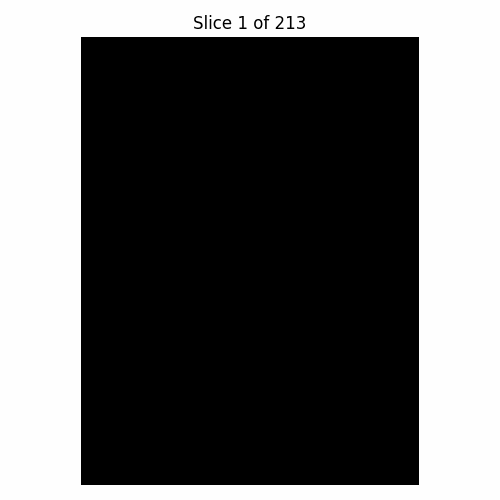

In [12]:
WIDTH = 400
HEIGHT = 300

[display(Image(filename=ct_scan_gif, width=WIDTH, height=HEIGHT)),
 display(Image(filename=ct_scan_segm_gif, width=WIDTH, height=HEIGHT))];

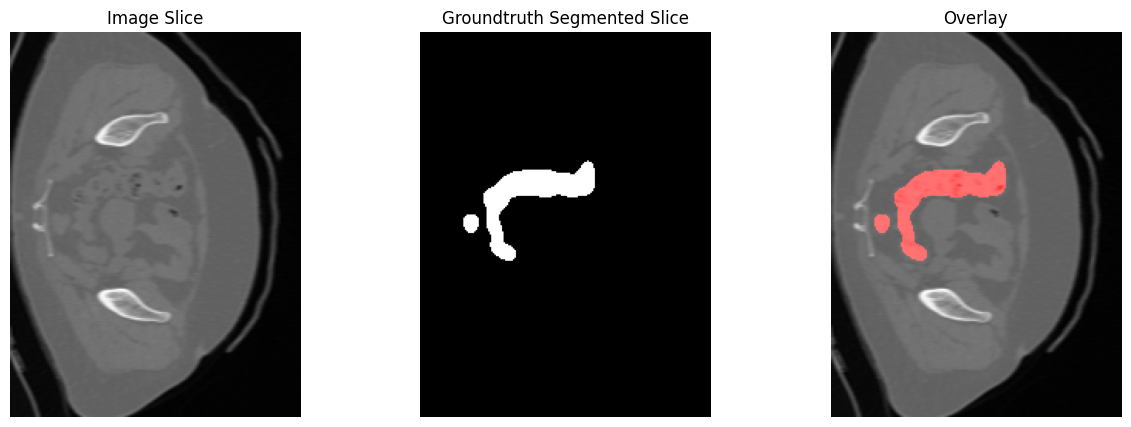

In [13]:

INDEX = 50

dicom_slice = load_nii_slice(ct_filepath, INDEX)
seg_slice = load_nii_segmentation(mask_filepath, INDEX)

# Create the overlay image
overlay_image = overlay_images(dicom_slice, seg_slice)

# Visualize all three images side by side
visualize_side_by_side(dicom_slice, seg_slice, overlay_image)


## Total Segmentator Example

In [ ]:
from totalsegmentator.python_api import totalsegmentator


In [15]:

dataset_folder = "Totalsegmentator_dataset_v201"
patient_ID = "s0001"
organ = "colon"

input_image_path =  os.path.join(DATA_PATH,  patient_ID, "ct.nii.gz" )
output_dir = os.path.join(PREDICTIONS_PATH, patient_ID)

print("Input file path: ", input_image_path)
print("Output directory: ", output_dir)

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load the input image (optional, for checking dimensions)
input_image = nib.load(input_image_path)
image_data = input_image.get_fdata()  # Get the image data as a NumPy array
print("Input Image Shape:", input_image.shape)


Input file path:  /home/catarina/Datasets/Totalsegmentator_dataset_v201/s0001/ct.nii.gz
Output directory:  /home/catarina/Documents/Github/med_seg_study/Predictions/s0001
Input Image Shape: (249, 188, 213)


In [16]:
# Define task and device
task = "total"       # Full-body segmentation
device = "gpu"       # Set to "mps" if using a mac with an M1 > chip, 
                     #"gpu" if available, otherwise "cpu"

try:
  seg_img, stats = totalsegmentator(input=input_image_path,
                                    output=output_dir,
                                    task=task,
                                    device=device,
                                    statistics=False)
except TypeError as e:
  print(f"An error occurred: {e}")

print("Segmentation Complete.")


No GPU detected. Running on CPU. This can be very slow. The '--fast' or the `--roi_subset` option can help to reduce runtime.

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 2.19s
Predicting part 1 of 5 ...


100%|██████████| 12/12 [00:49<00:00,  4.09s/it]


Predicting part 2 of 5 ...


100%|██████████| 12/12 [00:53<00:00,  4.48s/it]


Predicting part 3 of 5 ...


100%|██████████| 12/12 [00:53<00:00,  4.49s/it]


Predicting part 4 of 5 ...


100%|██████████| 12/12 [00:55<00:00,  4.62s/it]


Predicting part 5 of 5 ...


100%|██████████| 12/12 [00:56<00:00,  4.68s/it]


  Predicted in 304.55s
Resampling...
Saving segmentations...


  0%|          | 0/117 [00:00<?, ?it/s]

  Saved in 1.83s
An error occurred: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`
Segmentation Complete.


Predicted Mask Path:  /home/catarina/Documents/Github/med_seg_study/Predictions/s0001/colon.nii.gz
GroundTruth Mask Path:  /home/catarina/Datasets/Totalsegmentator_dataset_v201/s0001/segmentations/colon.nii.gz


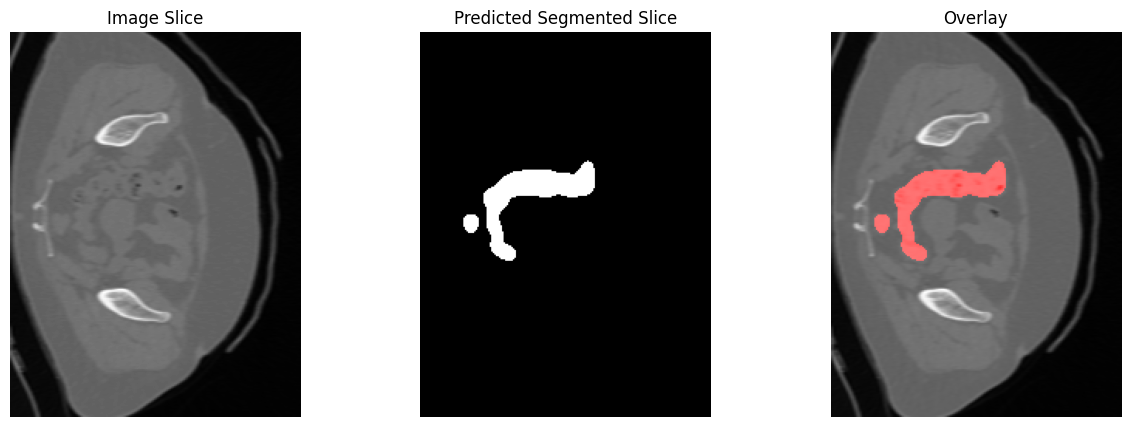

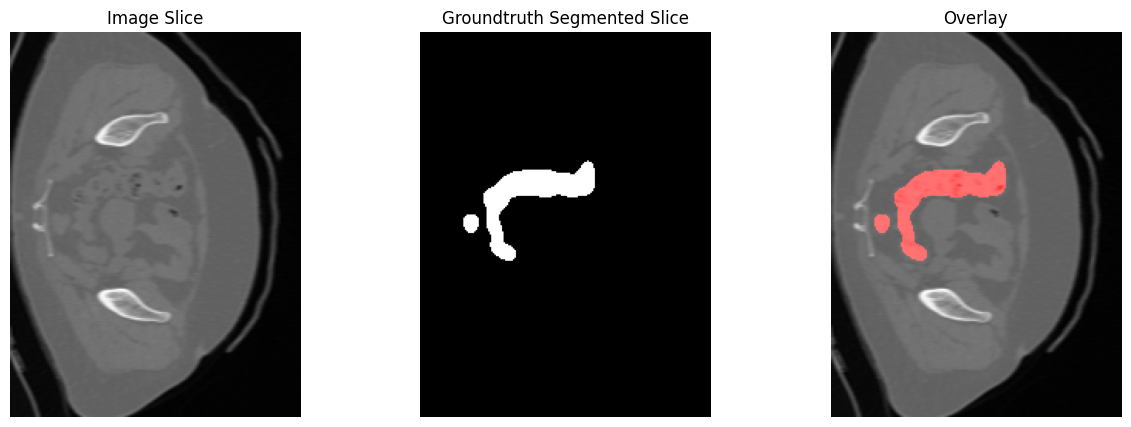

In [21]:
%matplotlib inline

INDEX = 50

path_to_mask = os.path.join(patient_ID, "segmentations", f"{organ}.nii.gz")
mask_filepath = os.path.join(DATA_PATH, path_to_mask)

predicted_mask_filepath = os.path.join(output_dir, "colon.nii.gz" )
PR_seg_slice = load_nii_segmentation(mask_filepath, INDEX)
print("Predicted Mask Path: ", predicted_mask_filepath)

groundtruth_mask_path = os.path.join(DATA_PATH,patient_ID, "segmentations", f"{organ}.nii.gz")
GT_seg_slice = load_nii_segmentation(groundtruth_mask_path, INDEX)
print("GroundTruth Mask Path: ", groundtruth_mask_path)

input_slice = load_nii_slice(input_image_path, INDEX)

# Create the overlay image
PR_overlay_image = overlay_images(input_slice, PR_seg_slice)
GT_overlay_image = overlay_images(input_slice, GT_seg_slice)

# Visualize all three images side by side
visualize_side_by_side(input_slice, PR_seg_slice, PR_overlay_image, isPrediction=True)
visualize_side_by_side(input_slice, GT_seg_slice, GT_overlay_image, isPrediction=False)

In [22]:
# Calculate metrics
print("Dice Similarity Coefficient:",  np.round(dice_coefficient(PR_seg_slice, GT_seg_slice), 4))
print("Intersection over Union (IoU):", np.round(iou(PR_seg_slice, GT_seg_slice), 4))
print("Mean Squared Error (MSE):", np.round(mean_squared_error(PR_seg_slice, GT_seg_slice), 4))
print("Pixel Accuracy:", np.round(pixel_accuracy(PR_seg_slice, GT_seg_slice), 4))


Dice Similarity Coefficient: 1.0
Intersection over Union (IoU): 1.0
Mean Squared Error (MSE): 0.0
Pixel Accuracy: 1.0


In [31]:
from IPython.display import HTML

mesh = generate_3d_reconstruction(groundtruth_mask_path, id=patient_ID);
reconstruction_path_GT = visualize_mesh(mesh, groundtruth_mask_path, id=patient_ID, opacity=1);
display(HTML(reconstruction_path_GT));

Saving mesh to /home/catarina/Documents/Github/med_seg_study/mesh/s0001/colon.nii.gz.vtk
Saving mesh to /home/catarina/Documents/Github/med_seg_study/3d_reconstruction/s0001/colon.nii.gz.html


In [32]:
%matplotlib inline
from IPython.display import HTML

mesh_PR = generate_3d_reconstruction(predicted_mask_filepath, id=patient_ID, isPrediction=True);
reconstruction_path_PR = visualize_mesh(mesh_PR, predicted_mask_filepath, id=patient_ID, opacity=1, isPrediction=True);
display(HTML(reconstruction_path_PR));


Saving mesh to /home/catarina/Documents/Github/med_seg_study/mesh/s0001/_pred.vtk
Saving mesh to /home/catarina/Documents/Github/med_seg_study/3d_reconstruction/s0001/_pred.html
